# Example 33 - Folded Layers

This example will show how to convert the geological map below using ``GemGIS`` to a `GemPy` model. This example is based on digitized data. The area is 601 m wide (W-E extent) and 705 m high (N-S extent). The vertical model extents varies between 0 m and 300 m. The model represents two folded stratigraphic units (blue and red) above an unspecified basement (yellow). The map has been georeferenced with QGIS. The stratigraphic boundaries were digitized in QGIS. Strikes lines were digitized in QGIS as well and were used to calculate orientations for the `GemPy` model. These will be loaded into the model directly. The contour lines were also digitized and will be interpolated with `GemGIS` to create a topography for the model. 

Map Source: Unknown

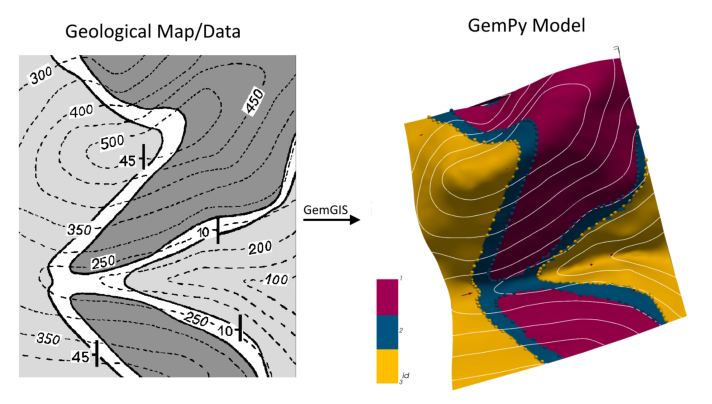

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('../images/cover_example33.png')
plt.figure(figsize=(10, 10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.tight_layout()

## Licensing

Computational Geosciences and Reservoir Engineering, RWTH Aachen University, Authors: Alexander Juestel. For more information contact: alexander.juestel(at)rwth-aachen.de


This work is licensed under a Creative Commons Attribution 4.0 International License (http://creativecommons.org/licenses/by/4.0/)

## Import GemGIS

If you have installed ``GemGIS`` via pip or conda, you can import ``GemGIS`` like any other package. If you have downloaded the repository, append the path to the directory where the ``GemGIS`` repository is stored and then import ``GemGIS``. 

In [2]:
import warnings
warnings.filterwarnings("ignore")
import gemgis as gg

## Importing Libraries and loading Data

All remaining packages can be loaded in order to prepare the data and to construct the model. The example data is downloaded from an external server using `pooch`. It will be stored in a data folder in the same directory where this notebook is stored.  

In [3]:
import geopandas as gpd
import rasterio

In [4]:
file_path = 'data/example33/'
gg.download_gemgis_data.download_tutorial_data(filename="example33_folded_layers.zip", dirpath=file_path)

## Creating Digital Elevation Model from Contour Lines

The digital elevation model (DEM) will be created by interpolating contour lines digitized from the georeferenced map using the `SciPy` Radial Basis Function interpolation wrapped in `GemGIS`. The respective function used for that is `gg.vector.interpolate_raster()`. 

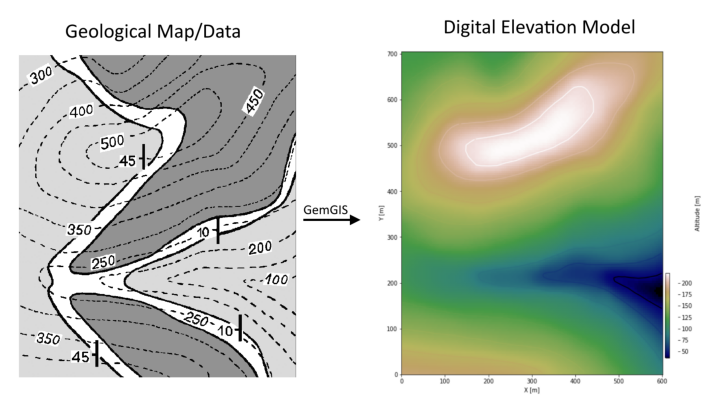

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('../images/dem_example33.png')
plt.figure(figsize=(10, 10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.tight_layout()

In [6]:
topo = gpd.read_file(file_path + 'topo33.shp')
# topo['Z'] = topo['Z']*0.425
topo.head()

,id,Z,geometry
0,None,400,"LINESTRING (0.994 52.851, 36.954 48.266, 68.32..."
1,None,350,"LINESTRING (1.235 98.706, 42.022 94.603, 80.39..."
2,None,300,"LINESTRING (1.477 157.955, 44.435 147.818, 81...."
3,None,300,"LINESTRING (1.597 320.738, 11.492 310.722, 22...."
4,None,250,"LINESTRING (553.299 3.497, 534.233 30.527, 513..."


### Interpolating the contour lines

In [7]:
topo_raster = gg.vector.interpolate_raster(gdf=topo, value='Z', method='rbf', res=5)

### Plotting the raster

(0.0, 705.0)

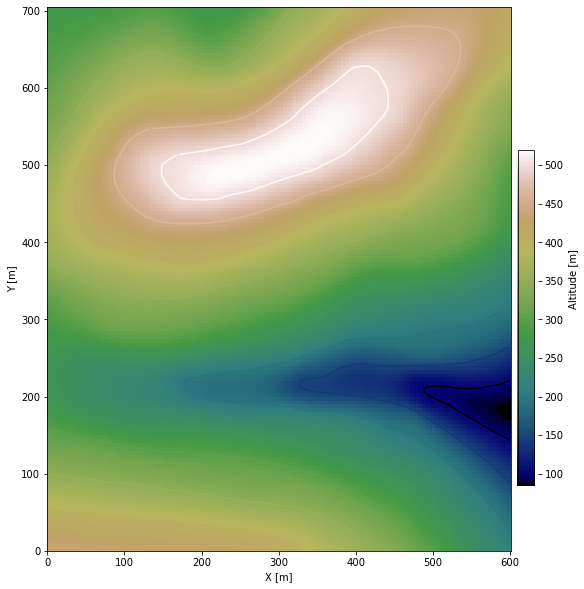

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize=(10, 10))
topo.plot(ax=ax, aspect='equal', column='Z', cmap='gist_earth')
im = ax.imshow(topo_raster, origin='lower', extent=[0, 601, 0, 705], cmap='gist_earth')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Altitude [m]')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
plt.xlim(0, 601)
plt.ylim(0, 705)

### Saving the raster to disc

After the interpolation of the contour lines, the raster is saved to disc using `gg.raster.save_as_tiff()`. The function will not be executed as a raster is already provided with the example data. 

In [9]:
gg.raster.save_as_tiff(raster=topo_raster, path=file_path + 'raster33.tif', extent=[0, 601, 0, 705], crs='EPSG:4326', overwrite_file=True)

Raster successfully saved


### Opening Raster

The previously computed and saved raster can now be opened using rasterio. 

In [10]:
topo_raster = rasterio.open(file_path + 'raster33.tif')

## Interface Points of stratigraphic boundaries

The interface points will be extracted from LineStrings digitized from the georeferenced map using QGIS. It is important to provide a formation name for each layer boundary. The vertical position of the interface point will be extracted from the digital elevation model using the `GemGIS` function `gg.vector.extract_xyz()`. The resulting GeoDataFrame now contains single points including the information about the respective formation. 

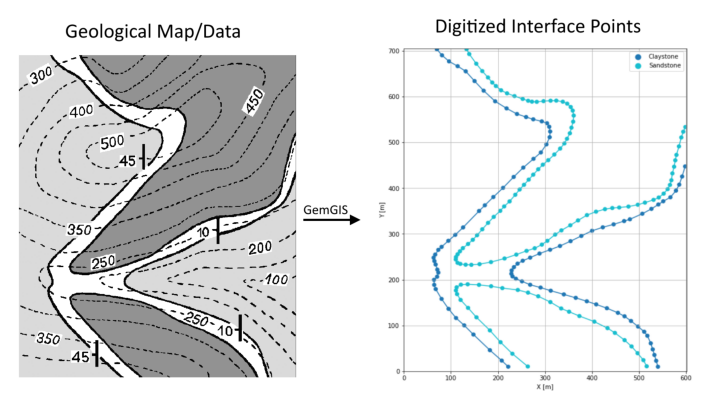

In [11]:
img = mpimg.imread('../images/interfaces_example33.png')
plt.figure(figsize=(10, 10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.tight_layout()

In [12]:
interfaces = gpd.read_file(file_path + 'interfaces33.shp')
interfaces.head()

,id,formation,geometry
0,None,Claystone,"LINESTRING (70.299 703.464, 81.050 690.563, 96..."
1,None,Sandstone,"LINESTRING (263.603 10.236, 230.705 38.189, 20..."
2,None,Claystone,"LINESTRING (598.176 447.589, 591.725 425.549, ..."
3,None,Sandstone,"LINESTRING (133.300 703.787, 138.998 693.251, ..."


### Extracting Z coordinate from Digital Elevation Model

In [13]:
interfaces_coords = gg.vector.extract_xyz(gdf=interfaces, dem=topo_raster)
interfaces_coords = interfaces_coords[interfaces_coords['formation'].isin(['Claystone','Sandstone'])]# 
interfaces_coords

,formation,geometry,X,Y,Z
0,Claystone,POINT (70.299 703.464),70.30,703.46,285.25
1,Claystone,POINT (81.050 690.563),81.05,690.56,291.10
2,Claystone,POINT (96.102 677.232),96.10,677.23,306.26
3,Claystone,POINT (114.378 666.696),114.38,666.70,322.26
4,Claystone,POINT (131.580 655.514),131.58,655.51,338.53
...,...,...,...,...,...
210,Sandstone,POINT (579.684 472.747),579.68,472.75,313.90
211,Sandstone,POINT (585.059 491.453),585.06,491.45,315.09
212,Sandstone,POINT (590.005 510.913),590.00,510.91,320.30
213,Sandstone,POINT (594.198 523.491),594.20,523.49,322.96


### Plotting the Interface Points

(0.0, 705.0)

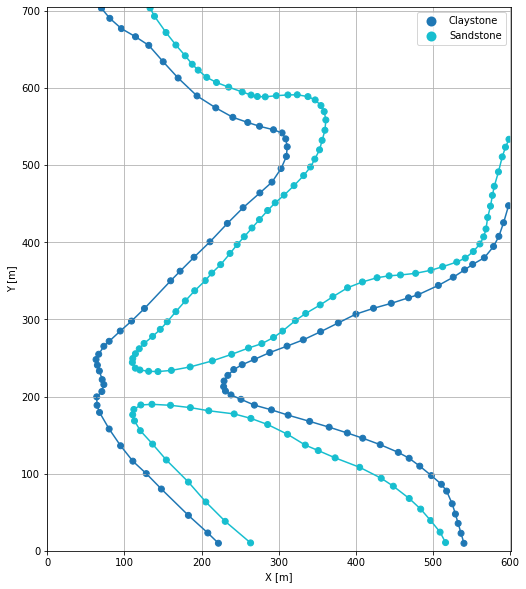

In [14]:
fig, ax = plt.subplots(1, figsize=(10, 10))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.xlim(0, 601)
plt.ylim(0, 705)

## Orientations from Strike Lines and Map

Strike lines connect outcropping stratigraphic boundaries (interfaces) of the same altitude. In other words: the intersections between topographic contours and stratigraphic boundaries at the surface. The height difference and the horizontal difference between two digitized lines is used to calculate the dip and azimuth and hence an orientation that is necessary for `GemPy`. In order to calculate the orientations, each set of strikes lines/LineStrings for one formation must be given an id number next to the altitude of the strike line. The id field is already predefined in QGIS. The strike line with the lowest altitude gets the id number `1`, the strike line with the highest altitude the the number according to the number of digitized strike lines. It is currently recommended to use one set of strike lines for each structural element of one formation as illustrated. 


In addition, orientations were provided on the map which were digitized as points and can be used right away.


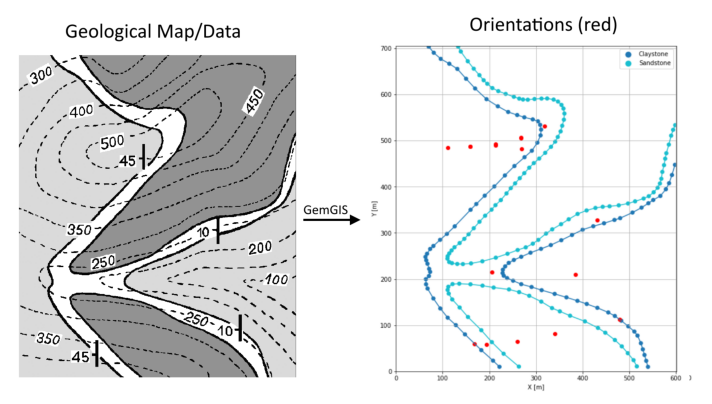

In [15]:
img = mpimg.imread('../images/orientations_example33.png')
plt.figure(figsize=(10, 10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.tight_layout()

### Orientations from Map

In [16]:
orientations_points = gpd.read_file(file_path + 'orientations33.shp')
orientations_points = gg.vector.extract_xyz(gdf=orientations_points, dem=topo_raster)
orientations_points

,formation,dip,azimuth,polarity,geometry,X,Y,Z
0,Claystone,225.00,270.00,1.00,POINT (168.241 59.261),168.24,59.26,373.80
1,Claystone,10.00,270.00,1.00,POINT (479.807 112.801),479.81,112.80,232.69
2,Claystone,10.00,270.00,1.00,POINT (431.642 328.037),431.64,328.04,247.93
3,Claystone,225.00,270.00,1.00,POINT (269.516 481.992),269.52,481.99,514.97
4,Claystone,89.00,90.00,1.00,POINT (41.918 218.780),41.92,218.78,249.89
5,Claystone,89.00,90.00,1.00,POINT (38.416 483.518),38.42,483.52,398.11
6,Claystone,89.00,90.00,1.00,POINT (52.067 77.344),52.07,77.34,365.65
7,Claystone,89.00,90.00,1.00,POINT (39.027 658.036),39.03,658.04,297.54
8,Claystone,1.00,270.00,1.00,POINT (113.787 658.036),113.79,658.04,333.16
9,Claystone,1.00,270.00,1.00,POINT (116.395 479.830),116.39,479.83,475.90


### Orientations from Strike Lines

In [17]:
strikes = gpd.read_file(file_path + 'strikes33.shp')
# strikes['Z'] = strikes['Z']*0.425
strikes

,id,formation,Z,geometry
0,5,Sandstone,500,"LINESTRING (342.516 586.923, 342.408 497.796)"
1,4,Sandstone,450,"LINESTRING (294.458 589.825, 293.168 448.987)"
2,3,Sandstone,400,"LINESTRING (244.359 598.426, 242.638 392.651)"
3,2,Sandstone,350,"LINESTRING (180.927 639.495, 184.583 331.155)"
4,1,Sandstone,300,"LINESTRING (135.558 699.486, 134.590 279.926)"
5,5,Claystone,500,"LINESTRING (294.136 545.477, 293.491 480.326)"
6,4,Claystone,450,"LINESTRING (244.251 560.744, 242.746 433.451)"
7,3,Claystone,400,"LINESTRING (181.465 601.598, 184.260 374.213)"
8,2,Claystone,350,"LINESTRING (135.235 650.838, 135.020 323.361)"
9,1,Claystone,300,"LINESTRING (86.426 684.811, 89.221 279.926)"


In [18]:
strikes[strikes['formation'] == 'Claystone']

,id,formation,Z,geometry
5,5,Claystone,500,"LINESTRING (294.136 545.477, 293.491 480.326)"
6,4,Claystone,450,"LINESTRING (244.251 560.744, 242.746 433.451)"
7,3,Claystone,400,"LINESTRING (181.465 601.598, 184.260 374.213)"
8,2,Claystone,350,"LINESTRING (135.235 650.838, 135.020 323.361)"
9,1,Claystone,300,"LINESTRING (86.426 684.811, 89.221 279.926)"


### Calculating Orientations for each formation

In [19]:
orientations_claystone1 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation'] == 'Claystone'].sort_values(by='id', ascending=True).reset_index())
orientations_claystone1['dip'] = orientations_claystone1['dip'] + 180
orientations_claystone1

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,227.33,269.78,325.00,POINT (111.476 484.734),1.00,Claystone,111.48,484.73
1,227.22,269.80,375.00,POINT (158.995 487.502),1.00,Claystone,159.00,487.50
2,220.18,269.62,425.00,POINT (213.181 492.502),1.00,Claystone,213.18,492.50
3,224.96,270.65,475.00,POINT (268.656 505.000),1.00,Claystone,268.66,505.00


In [20]:
orientations_claystone2 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation'] == 'Claystone2'].sort_values(by='id', ascending=True).reset_index())
orientations_claystone2

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,10.16,269.26,225.00,POINT (384.875 210.152),1.00,Claystone2,384.87,210.15


In [21]:
orientations_sandstone1 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation'] == 'Sandstone'].sort_values(by='id', ascending=True).reset_index())
orientations_sandstone1

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,47.69,269.85,325.00,POINT (158.915 487.516),1.00,Sandstone,158.91,487.52
1,40.39,269.68,375.00,POINT (213.127 490.432),1.00,Sandstone,213.13,490.43
2,44.97,270.49,425.00,POINT (268.656 507.472),1.00,Sandstone,268.66,507.47
3,46.12,270.39,475.00,POINT (318.138 530.883),1.00,Sandstone,318.14,530.88


### Merging Orientations

In [22]:
import pandas as pd
orientations = pd.concat([orientations_points, orientations_claystone1, orientations_claystone2])#, orientations_sandstone1])#, orientations_sandstone2, ])
orientations['formation'] = ['Claystone', 'Claystone', 'Claystone', 'Claystone','Claystone', 'Claystone', 'Claystone', 'Claystone','Claystone', 'Claystone','Claystone', 'Claystone', 'Claystone', 'Claystone','Claystone', 'Claystone', 'Claystone', 'Claystone', 'Claystone', 'Claystone','Claystone','Claystone', 'Claystone']#, 'Claystone', 'Claystone', 'Claystone']#, 'Sandstone', 'Sandstone', 'Sandstone', 'Sandstone']#, 'Sandstone']
orientations = orientations[orientations['formation'].isin(['Claystone', 'Sandstone'])].reset_index()
orientations.at[4, 'Z'] = 300
orientations.at[5, 'Z'] = 300
orientations.at[6, 'Z'] = 300
orientations.at[7, 'Z'] = 300

orientations.at[8, 'Z'] = 100
orientations.at[9, 'Z'] = 100
orientations.at[10, 'Z'] = 100
orientations.at[11, 'Z'] = 100

orientations.at[12, 'Z'] = 250
orientations.at[13, 'Z'] = 250
orientations.at[14, 'Z'] = 250
orientations.at[15, 'Z'] = 250
orientations.at[16, 'Z'] = 250
orientations.at[17, 'Z'] = 250
orientations

,index,formation,dip,azimuth,polarity,geometry,X,Y,Z
0,0,Claystone,225.00,270.00,1.00,POINT (168.241 59.261),168.24,59.26,373.80
1,1,Claystone,10.00,270.00,1.00,POINT (479.807 112.801),479.81,112.80,232.69
2,2,Claystone,10.00,270.00,1.00,POINT (431.642 328.037),431.64,328.04,247.93
3,3,Claystone,225.00,270.00,1.00,POINT (269.516 481.992),269.52,481.99,514.97
4,4,Claystone,89.00,90.00,1.00,POINT (41.918 218.780),41.92,218.78,300.00
5,5,Claystone,89.00,90.00,1.00,POINT (38.416 483.518),38.42,483.52,300.00
6,6,Claystone,89.00,90.00,1.00,POINT (52.067 77.344),52.07,77.34,300.00
7,7,Claystone,89.00,90.00,1.00,POINT (39.027 658.036),39.03,658.04,300.00
8,8,Claystone,1.00,270.00,1.00,POINT (113.787 658.036),113.79,658.04,100.00
9,9,Claystone,1.00,270.00,1.00,POINT (116.395 479.830),116.39,479.83,100.00


### Plotting the Orientations

(0.0, 705.0)

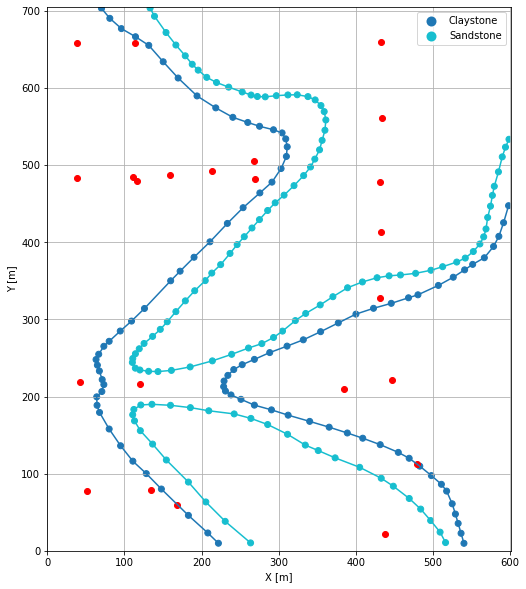

In [23]:
fig, ax = plt.subplots(1, figsize=(10, 10))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
orientations.plot(ax=ax, color='red', aspect='equal')
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.xlim(0, 601)
plt.ylim(0, 705)

## GemPy Model Construction

The structural geological model will be constructed using the `GemPy` package. 

In [24]:
import gempy as gp

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Creating new Model

In [25]:
geo_model = gp.create_model('Model33')
geo_model

Model33  2022-04-17 21:57

### Initiate Data

In [26]:
gp.init_data(geo_model, [0, 601, 0, 705, 0, 300], [50,50,50],
             surface_points_df=interfaces_coords,
             orientations_df=orientations,
             default_values=True)

Active grids: ['regular']


Model33  2022-04-17 21:57

### Model Surfaces

In [27]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Claystone,Default series,1,#015482,1
1,Sandstone,Default series,2,#9f0052,2


### Mapping the Stack to Surfaces

In [28]:
gp.map_stack_to_surfaces(geo_model,
                         {'Strata1': ( 'Sandstone', 'Claystone'), #
                          },
                         remove_unused_series=True)
geo_model.add_surfaces('Sandstein')

,surface,series,order_surfaces,color,id
0,Claystone,Strata1,1,#015482,1
1,Sandstone,Strata1,2,#9f0052,2
2,Sandstein,Strata1,3,#ffbe00,3


### Showing the Number of Data Points

In [29]:
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,color,id,No. of Interfaces,No. of Orientations
0,Claystone,Strata1,1,#015482,1,96,23
1,Sandstone,Strata1,2,#9f0052,2,119,0
2,Sandstein,Strata1,3,#ffbe00,3,0,0


### Loading Digital Elevation Model

In [30]:
geo_model.set_topography(source='gdal', filepath=file_path + 'raster33.tif')

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[  6.01      ,   7.05      ,   3.        ],
       [  6.01      ,   7.05      ,   9.        ],
       [  6.01      ,   7.05      ,  15.        ],
       ...,
       [598.49583333, 692.5       , 414.02352905],
       [598.49583333, 697.5       , 414.65353394],
       [598.49583333, 702.5       , 415.13659668]])

### Plotting Input Data

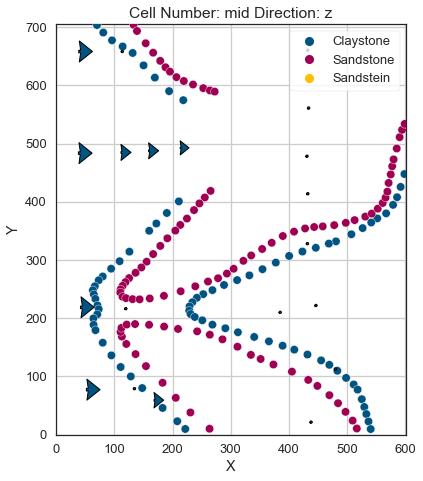

In [31]:
gp.plot_2d(geo_model, direction='z', show_lith=False, show_boundaries=False)
plt.grid()

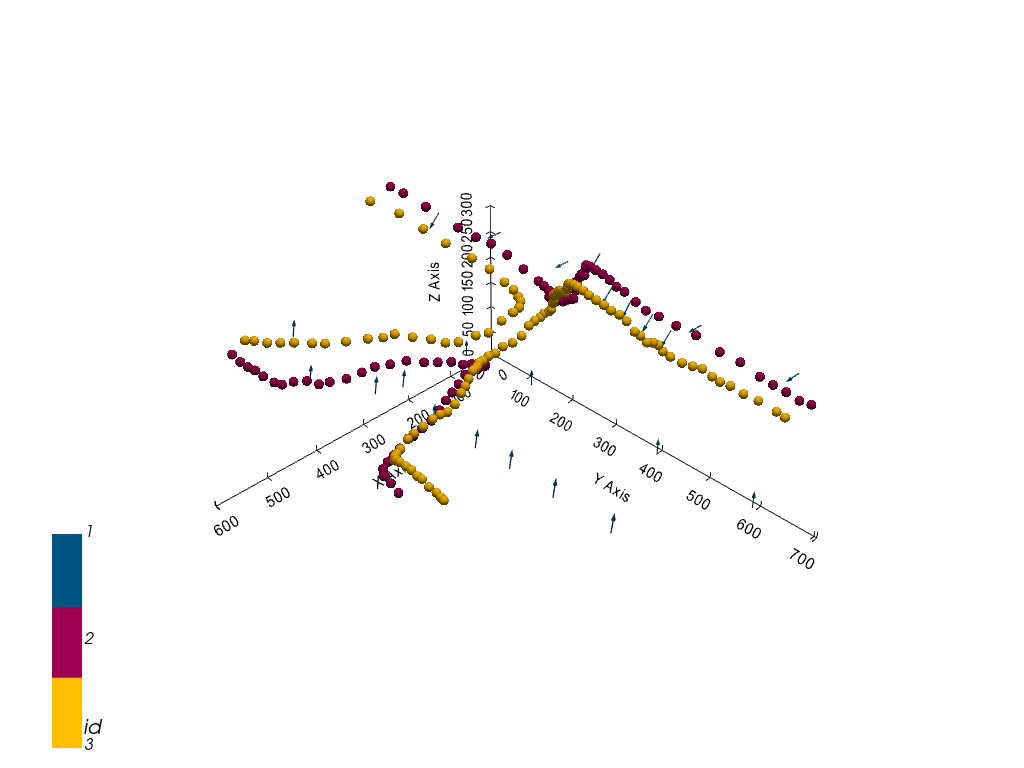

In [32]:
gp.plot_3d(geo_model, image=False, plotter_type='basic', notebook=True)

### Setting the Interpolator

In [33]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging=False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range             973.77
$C_o$           22576.81
drift equations      [3]


### Computing Model

In [34]:
sol = gp.compute_model(geo_model, compute_mesh=True)

### Plotting Cross Sections

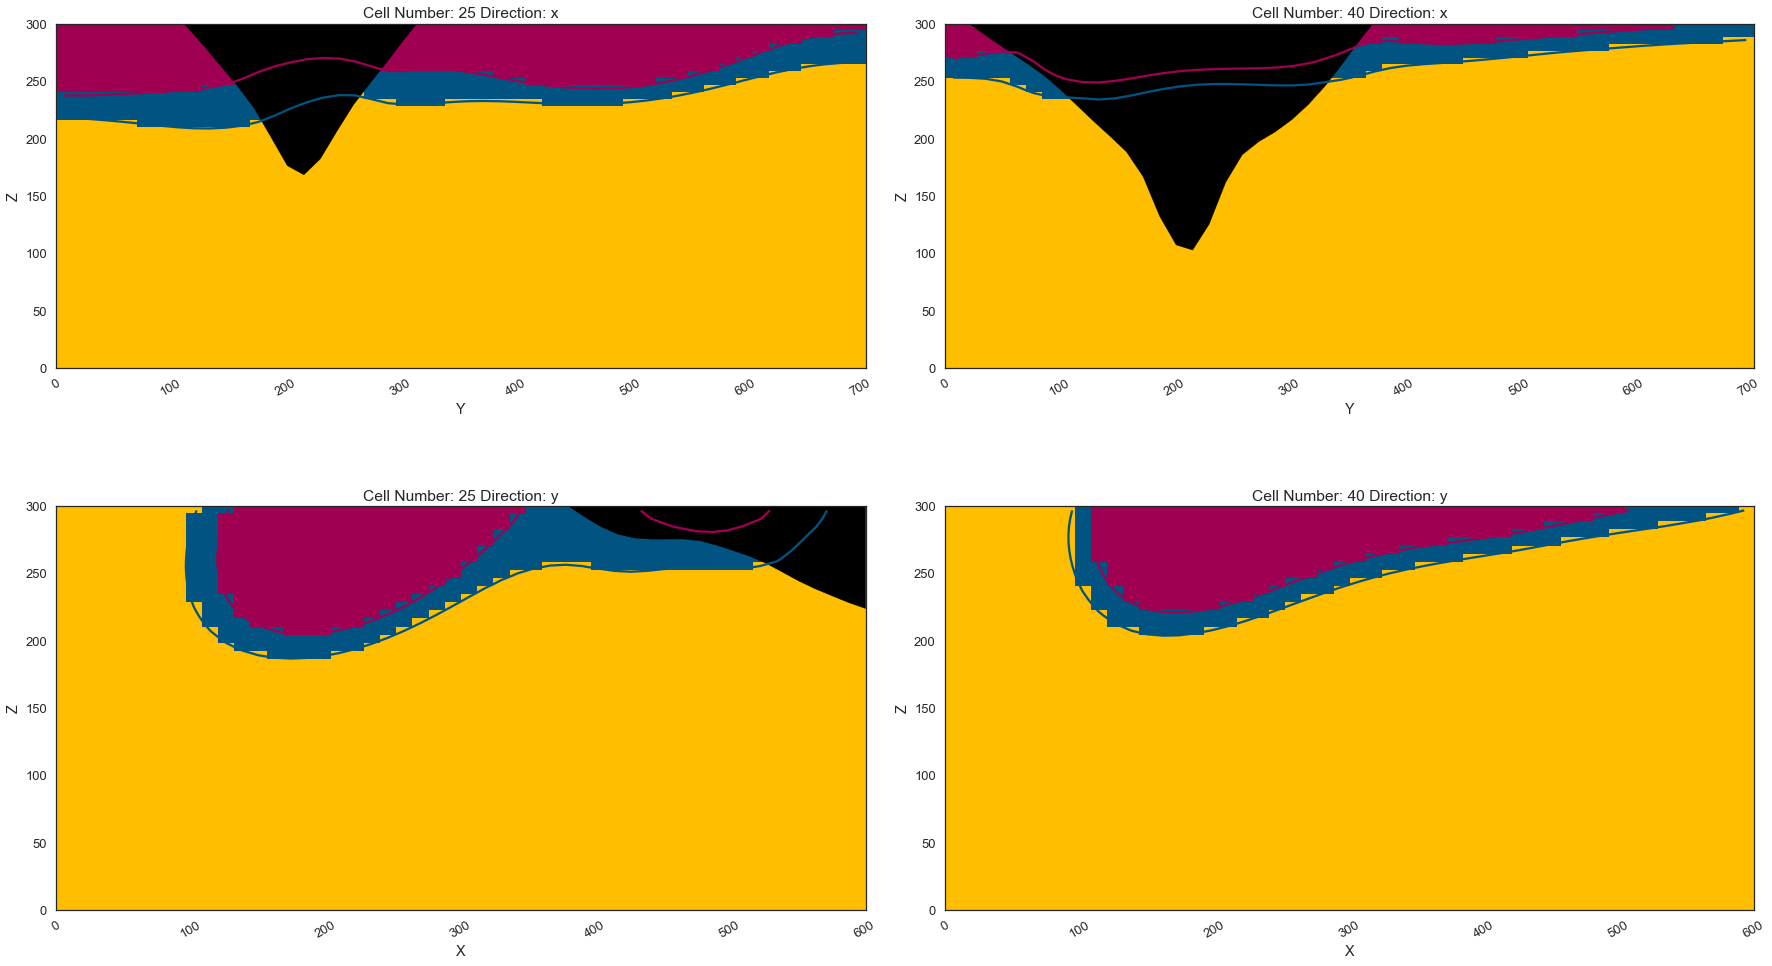

In [35]:
gp.plot_2d(geo_model, direction=['x', 'x', 'y', 'y'], cell_number=[25, 40, 25, 40], show_topography=True, show_data=False)

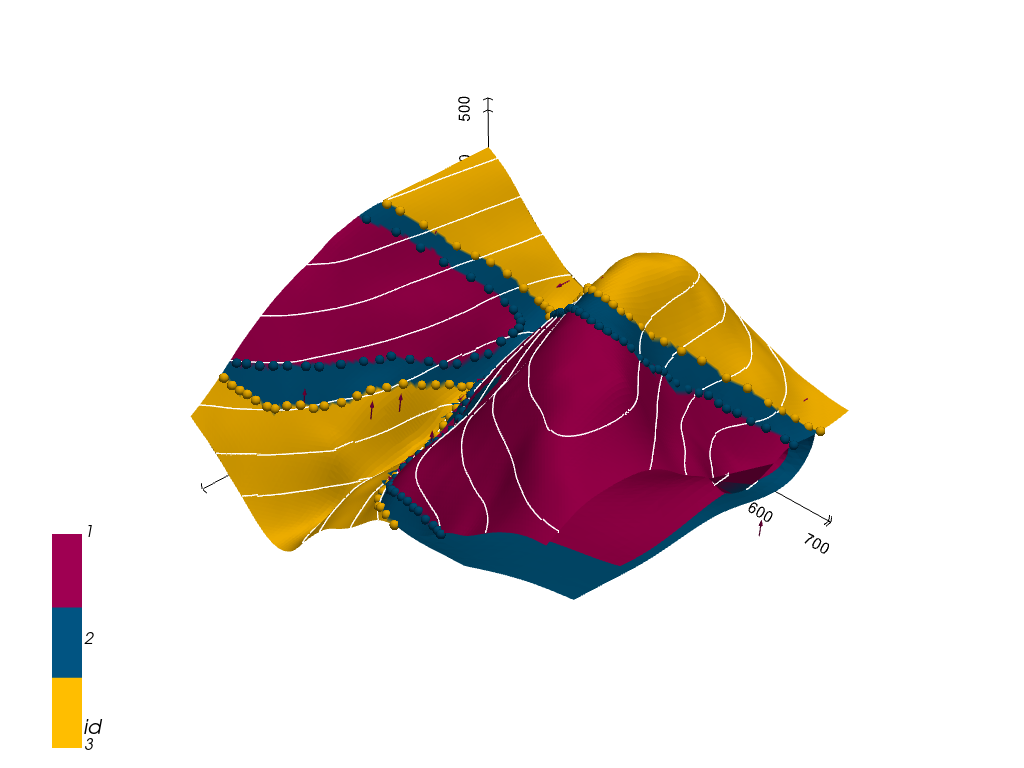

In [36]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=True,
                 plotter_type='basic', notebook=True, show_lith=False)